### Stock Market Prediction using Numerical and Textual Analysis
- Create a hybrid model for stock price or performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines. The stock to analyze and predict is SENSEX (S&P BSE SENSEX)

# Import the Important Libraries

In [168]:
# Import the libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import nltk
import re
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost
import lightgbm

In [131]:
# For reading stock data from yahoo
from pandas_datareader.data import DataReader
# For time stamps
from datetime import datetime

In [132]:
# Load the first dataset
columns=['Date','Category','News']
ndf = pd.read_csv("india-news-headlines.csv",names=columns)

In [133]:
print('Showing part of the whole dataset:')
ndf.head(5)

Showing part of the whole dataset:


,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010101,sports.wwe,win over cena satisfying but defeating underta...
2,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
3,20010102,unknown,Fissures in Hurriyat over Pak visit
4,20010102,unknown,America's unwanted heading for India?


In [134]:
ndf.drop(0, inplace=True)
ndf.drop('Category', axis = 1, inplace=True)
print('Showing part of the whole dataset:')
ndf.head(-5)

Showing part of the whole dataset:


,Date,News
1,20010101,win over cena satisfying but defeating underta...
2,20010102,Status quo will not be disturbed at Ayodhya; s...
3,20010102,Fissures in Hurriyat over Pak visit
4,20010102,America's unwanted heading for India?
5,20010102,For bigwigs; it is destination Goa
...,...,...
3297163,20200630,vehicle of up stf team bringing gangster vikas...
3297164,20200630,sushant singh rajputs demise fans trend cbifor...
3297165,20200630,amitabh bachchans grandson agastya nanda prepp...
3297166,20200630,icse isc result 2020 when where to check class...


In [135]:
# Load the second dataset
hisdf = pd.read_csv("^BSESN.csv")
hisdf.head(-5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-12-14,24935.599609,25194.150391,24867.730469,25150.349609,25150.349609,11600.0
1,2015-12-15,25186.679688,25342.779297,25075.539063,25320.439453,25320.439453,9700.0
2,2015-12-16,25402.470703,25572.900391,25372.470703,25494.369141,25494.369141,10800.0
3,2015-12-17,25596.630859,25831.310547,25448.320313,25803.779297,25803.779297,22700.0
4,2015-12-18,25764.669922,25789.509766,25481.509766,25519.220703,25519.220703,10400.0
...,...,...,...,...,...,...,...
1224,2020-11-27,44325.031250,44407.281250,43995.410156,44149.718750,44149.718750,15700.0
1225,2020-12-01,44435.828125,44730.789063,44118.101563,44655.441406,44655.441406,16000.0
1226,2020-12-02,44729.519531,44729.640625,44169.968750,44618.039063,44618.039063,16000.0
1227,2020-12-03,44902.019531,44953.011719,44551.421875,44632.648438,44632.648438,30700.0


# Common Dataset Exploration

In [136]:
# Check for common information of the first datast
ndf["Date"] = pd.to_datetime(ndf["Date"],format='%Y%m%d')
ndf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3297172 entries, 1 to 3297172
Data columns (total 2 columns):
 #   Column  Dtype         
---  ------  -----         
 0   Date    datetime64[ns]
 1   News    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 75.5+ MB


In [137]:
# Group the headlines for each day
ndf['News'] = ndf.groupby(['Date']).transform(lambda x : ' '.join(x)) 
ndf = ndf.drop_duplicates() 
ndf.reset_index(inplace=True,drop=True)

In [138]:
ndf

,Date,News
0,2001-01-01,win over cena satisfying but defeating underta...
1,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2,2001-01-03,Powerless north India gropes in the dark Think...
3,2001-01-04,The string that pulled Stephen Hawking to Indi...
4,2001-01-05,Light combat craft takes India into club class...
...,...,...
7075,2020-06-26,Containment zone residents slam high prices ch...
7076,2020-06-27,like me i wont let you have a toxic relationsh...
7077,2020-06-28,Atanu Ghosh plans to rewrite old scripts to ma...
7078,2020-06-29,6 hot and stylish bikini looks of Katrina Kaif...


In [139]:
# Check for any duplicated values
ndf.isnull().sum()

Date    0
News    0
dtype: int64

In [140]:
len(ndf)

7080

In [141]:
hisdf=hisdf[["Date","Open","High","Low","Close","Volume"]]
hisdf.head(-5)

,Date,Open,High,Low,Close,Volume
0,2015-12-14,24935.599609,25194.150391,24867.730469,25150.349609,11600.0
1,2015-12-15,25186.679688,25342.779297,25075.539063,25320.439453,9700.0
2,2015-12-16,25402.470703,25572.900391,25372.470703,25494.369141,10800.0
3,2015-12-17,25596.630859,25831.310547,25448.320313,25803.779297,22700.0
4,2015-12-18,25764.669922,25789.509766,25481.509766,25519.220703,10400.0
...,...,...,...,...,...,...
1224,2020-11-27,44325.031250,44407.281250,43995.410156,44149.718750,15700.0
1225,2020-12-01,44435.828125,44730.789063,44118.101563,44655.441406,16000.0
1226,2020-12-02,44729.519531,44729.640625,44169.968750,44618.039063,16000.0
1227,2020-12-03,44902.019531,44953.011719,44551.421875,44632.648438,30700.0


In [142]:
# Check for common information of the second dataset
hisdf["Date"]= pd.to_datetime(hisdf["Date"])
hisdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1234 entries, 0 to 1233
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1234 non-null   datetime64[ns]
 1   Open    1229 non-null   float64       
 2   High    1229 non-null   float64       
 3   Low     1229 non-null   float64       
 4   Close   1229 non-null   float64       
 5   Volume  1229 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 58.0 KB


In [143]:
hisdf.describe()

,Open,High,Low,Close,Volume
count,1229.000000,1229.000000,1229.000000,1229.000000,1.229000e+03
mean,33612.537529,33770.774116,33378.082519,33568.855966,2.737271e+05
std,5145.385399,5155.580751,5113.753852,5134.402915,2.123753e+06
min,23060.390625,23142.960938,22494.609375,22951.830078,2.500000e+03
25%,29006.000000,29077.279297,28789.300781,28929.130859,1.050000e+04
50%,34167.531250,34351.339844,33949.460938,34142.148438,1.430000e+04
75%,37840.640625,38022.320313,37586.878906,37752.171875,1.980000e+04
max,46060.320313,46309.628906,45792.011719,46103.500000,3.181510e+07


In [145]:
len(hisdf)

1234

# Remove Unwanted Characters from the News

In [148]:
#removing unwanted characters from the News
ndf.replace("[^a-zA-Z']"," ",regex=True,inplace=True)
ndf["News"].head(5)

0    win over cena satisfying but defeating underta...
1    Status quo will not be disturbed at Ayodhya  s...
2    Powerless north India gropes in the dark Think...
3    The string that pulled Stephen Hawking to Indi...
4    Light combat craft takes India into club class...
Name: News, dtype: object

In [77]:
# Train test split
train = hisdf[:1219]
test = hisdf[1219:]

In [82]:
#Using auto arima to make predictions using log data
from pmdarima import auto_arima

In [83]:
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(periods = len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-7372.030, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7379.211, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7382.510, Time=0.68 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7382.013, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7379.290, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-7382.581, Time=0.24 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-7383.659, Time=0.58 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-7381.766, Time=0.29 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-7381.633, Time=1.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-7380.186, Time=0.51 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-7379.695, Time=1.39 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-7383.838, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-7382.575, Time=0.22 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-7381.915, Time=0.29 sec
 ARIMA(3,1,1)(0,0,0

Text(0, 0.5, 'Actual Stock Price')

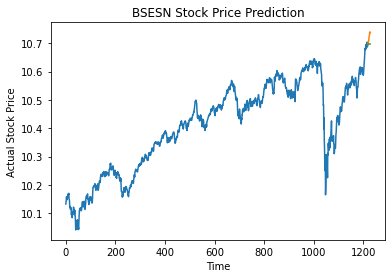

In [87]:
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

# Error Calculation

In [88]:
#Calculating error
rms = np.sqrt(mean_squared_error(test_log,predictions))
print("RMSE : ", rms)

RMSE :  0.026837616405067617


# Textual Analysis

In [89]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [90]:
#Adding subjectivity and polarity columns
ndf['Subjectivity'] = ndf['News'].apply(getSubjectivity)
ndf['Polarity'] = ndf['News'].apply(getPolarity)
ndf

,Date,News,Subjectivity,Polarity
0,2001-01-01,win over cena satisfying but defeating underta...,0.633333,0.433333
1,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590
2,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286
3,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039
4,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024
...,...,...,...,...
7075,2020-06-26,Containment zone residents slam high prices ch...,0.377957,0.060128
7076,2020-06-27,like me i wont let you have a toxic relationsh...,0.390221,0.080373
7077,2020-06-28,Atanu Ghosh plans to rewrite old scripts to ma...,0.397919,0.058824
7078,2020-06-29,hot and stylish bikini looks of Katrina Kaif...,0.397084,0.065397


In [91]:
#Adding sentiment score to df_news
sia = SentimentIntensityAnalyzer()

In [92]:
ndf['Compound'] = [sia.polarity_scores(v)['compound'] for v in ndf['News']]
ndf['Negative'] = [sia.polarity_scores(v)['neg'] for v in ndf['News']]
ndf['Neutral'] = [sia.polarity_scores(v)['neu'] for v in ndf['News']]
ndf['Positive'] = [sia.polarity_scores(v)['pos'] for v in ndf['News']]
ndf

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-01,win over cena satisfying but defeating underta...,0.633333,0.433333,-0.0000,0.230,0.473,0.297
1,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590,-0.9792,0.121,0.809,0.071
2,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286,-0.8910,0.156,0.735,0.109
3,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039,0.7543,0.104,0.792,0.104
4,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024,0.9645,0.142,0.694,0.164
...,...,...,...,...,...,...,...,...
7075,2020-06-26,Containment zone residents slam high prices ch...,0.377957,0.060128,-0.9999,0.170,0.738,0.092
7076,2020-06-27,like me i wont let you have a toxic relationsh...,0.390221,0.080373,-0.9999,0.162,0.743,0.095
7077,2020-06-28,Atanu Ghosh plans to rewrite old scripts to ma...,0.397919,0.058824,-0.9999,0.156,0.767,0.077
7078,2020-06-29,hot and stylish bikini looks of Katrina Kaif...,0.397084,0.065397,-0.9999,0.151,0.760,0.090


# Merge the Historical and Textual Data

In [108]:
df_merge = pd.merge(hisdf, ndf, how='inner', on='Date')
df_merge

,Date,Open,High,Low,Close,Volume,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2015-12-14,24935.599609,25194.150391,24867.730469,25150.349609,11600.0,things men do that make women fall deeper i...,0.472105,0.100389,-0.9996,0.153,0.719,0.128
1,2015-12-15,25186.679688,25342.779297,25075.539063,25320.439453,9700.0,Do looks matter at workplace Common running m...,0.421103,0.074733,-0.9999,0.149,0.745,0.106
2,2015-12-16,25402.470703,25572.900391,25372.470703,25494.369141,10800.0,In pics foods that make you smarter Dos and...,0.434933,0.111113,-0.9724,0.107,0.786,0.107
3,2015-12-17,25596.630859,25831.310547,25448.320313,25803.779297,22700.0,sex secrets every woman must know You too ca...,0.389598,0.058890,-0.9997,0.150,0.735,0.115
4,2015-12-18,25764.669922,25789.509766,25481.509766,25519.220703,10400.0,Stop making THESE diet disasters How to get s...,0.412045,0.071201,-0.9999,0.161,0.726,0.113
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1109,2020-06-24,35679.738281,35706.550781,34794.929688,34868.980469,26600.0,I never thought I had a voice until today Vid...,0.385245,0.087935,-0.9999,0.139,0.782,0.080
1110,2020-06-25,34525.390625,35081.609375,34499.781250,34842.101563,24600.0,Truck firms look for new export markets to sel...,0.398419,0.028698,-0.9999,0.145,0.789,0.066
1111,2020-06-26,35144.781250,35254.878906,34910.339844,35171.269531,24800.0,Containment zone residents slam high prices ch...,0.377957,0.060128,-0.9999,0.170,0.738,0.092
1112,2020-06-29,34926.949219,35032.359375,34662.058594,34961.519531,18300.0,hot and stylish bikini looks of Katrina Kaif...,0.397084,0.065397,-0.9999,0.151,0.760,0.090


# Create Dataset for Model Training

In [113]:
dfmerge1 = df_merge[['Close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral', 'Positive']]
dfmerge1

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,25150.349609,0.472105,0.100389,-0.9996,0.153,0.719,0.128
1,25320.439453,0.421103,0.074733,-0.9999,0.149,0.745,0.106
2,25494.369141,0.434933,0.111113,-0.9724,0.107,0.786,0.107
3,25803.779297,0.389598,0.058890,-0.9997,0.150,0.735,0.115
4,25519.220703,0.412045,0.071201,-0.9999,0.161,0.726,0.113
...,...,...,...,...,...,...,...
1109,34868.980469,0.385245,0.087935,-0.9999,0.139,0.782,0.080
1110,34842.101563,0.398419,0.028698,-0.9999,0.145,0.789,0.066
1111,35171.269531,0.377957,0.060128,-0.9999,0.170,0.738,0.092
1112,34961.519531,0.397084,0.065397,-0.9999,0.151,0.760,0.090


# Normalize Data

In [115]:
scaler = MinMaxScaler()

df = pd.DataFrame(scaler.fit_transform(dfmerge1))
df.columns = dfmerge1.columns
df.index = dfmerge1.index
df.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.115707,1.000000,0.804262,0.000200,0.496063,0.131034,0.837209
1,0.124658,0.637680,0.618084,0.000050,0.464567,0.310345,0.581395
2,0.133812,0.735928,0.882084,0.013803,0.133858,0.593103,0.593023
3,0.150096,0.413875,0.503113,0.000150,0.472441,0.241379,0.686047
4,0.135120,0.573336,0.592454,0.000050,0.559055,0.179310,0.662791


In [116]:
X=df.drop('Close',axis=1)
X

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,1.000000,0.804262,0.000200,0.496063,0.131034,0.837209
1,0.637680,0.618084,0.000050,0.464567,0.310345,0.581395
2,0.735928,0.882084,0.013803,0.133858,0.593103,0.593023
3,0.413875,0.503113,0.000150,0.472441,0.241379,0.686047
4,0.573336,0.592454,0.000050,0.559055,0.179310,0.662791
...,...,...,...,...,...,...
1109,0.382947,0.713887,0.000050,0.385827,0.565517,0.279070
1110,0.476536,0.284023,0.000050,0.433071,0.613793,0.116279
1111,0.331174,0.512097,0.000050,0.629921,0.262069,0.418605
1112,0.467056,0.550338,0.000050,0.480315,0.413793,0.395349


In [118]:
Y=df['Close']
Y

0       0.115707
1       0.124658
2       0.133812
3       0.150096
4       0.135120
          ...   
1109    0.627192
1110    0.625777
1111    0.643101
1112    0.632062
1113    0.629656
Name: Close, Length: 1114, dtype: float64

# Split the Dataset into Train & Test Data

In [119]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)
x_train.shape

(891, 6)

In [149]:
x_train[:10]

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
927,0.484416,0.739807,0.00005,0.590551,0.144828,0.674419
876,0.265810,0.484699,0.00005,0.598425,0.241379,0.511628
1050,0.402516,0.605501,0.00015,0.440945,0.344828,0.558140
1081,0.393804,0.604870,0.00015,0.377953,0.448276,0.476744
658,0.484525,0.393420,0.00005,0.307087,0.648276,0.244186
622,0.362822,0.174151,0.00000,0.677165,0.213793,0.430233
965,0.421373,0.338042,0.00005,0.566929,0.393103,0.302326
818,0.298472,0.603939,0.00005,0.535433,0.420690,0.302326
787,0.356953,0.474171,0.00005,0.566929,0.379310,0.302326
920,0.466131,0.428890,0.00010,0.433071,0.448276,0.395349


# RandomForestRegressor Model

In [150]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)

In [151]:
print(prediction[:10])
print(y_test[:10])
print('Mean Squared error: ',mean_squared_error(prediction,y_test))

[0.59204602 0.77743871 0.46716064 0.73144085 0.25611568 0.33254211
 0.63953336 0.683319   0.59969559 0.26583055]
1006    0.966906
1109    0.627192
187     0.299075
896     0.723549
413     0.465435
501     0.578316
546     0.591144
881     0.839169
959     0.903342
268     0.228219
Name: Close, dtype: float64
Mean Squared error:  0.05257968397499098


# DecisionTreeRegressor Model

In [153]:
dtr = DecisionTreeRegressor()
dtr.fit(x_train, y_train)
predictions = dtr.predict(x_test)

In [154]:
print(predictions[:10])
print(y_test[:10])
print('Mean Squared error: ',mean_squared_error(predictions,y_test))

[0.46121848 0.98284344 0.69232194 0.71547783 0.19176137 0.28527224
 0.88757586 0.69698498 0.23569794 0.11570669]
1006    0.966906
1109    0.627192
187     0.299075
896     0.723549
413     0.465435
501     0.578316
546     0.591144
881     0.839169
959     0.903342
268     0.228219
Name: Close, dtype: float64
Mean Squared error:  0.10831900809236311


# AdaBoostRegressor Model

In [165]:
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)

AdaBoostRegressor()

In [167]:
predictions = adb.predict(x_test)
print(mean_squared_error(predictions, y_test))

0.05492347045438241


# LGBMRegressor Model

In [163]:
gbm = lightgbm.LGBMRegressor()
gbm.fit(x_train, y_train)

LGBMRegressor()

In [160]:
predictions = gbm.predict(x_test)
print(mean_squared_error(predictions, y_test))

0.0583079056070462


# XGBRegressor Model

In [162]:
xgb = xgboost.XGBRegressor()
xgb.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [164]:
predictions = xgb.predict(x_test)
print(mean_squared_error(predictions, y_test))

0.05968830860645931


# Conclusion

- RandomForest = 0.05257968397499098
- DecisionTree = 0.10831900809236311
- AdaBoost = 0.05492347045438241
- LightGBM = 0.0583079056070462
- XGBoost = 0.05968830860645931
From here we can see that RandomForestRegressor shows a better performance than the others